In [2]:
import numpy as np
import tensorflow as tf

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import utils

import os
from os.path import join as pjoin
import sys
import copy

import models.nn4 as network

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
tf.reset_default_graph()
sess = tf.Session()
saver = tf.train.import_meta_graph('../models/model-20170512-110547.meta')
saver.restore(sess, '../models/model-20170512-110547.ckpt-250000')
images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from ../models/model-20170512-110547.ckpt-250000


In [4]:
def load_data(data_dir):
    data = {}
    pics_ctr = 0
    for guy in os.listdir(data_dir):
        person_dir = pjoin(data_dir, guy)
        curr_pics = [utils.preproc(cv2.imread(pjoin(person_dir, f))) for f in os.listdir(person_dir)]
        if len(curr_pics) < 2 or np.random.random() > 0.5:
            continue
        if pics_ctr > 100:
            break
        data[guy] = curr_pics
        pics_ctr += len(curr_pics)
    return data, pics_ctr

Loaded 108 pics.
Random guy from LFW dataset


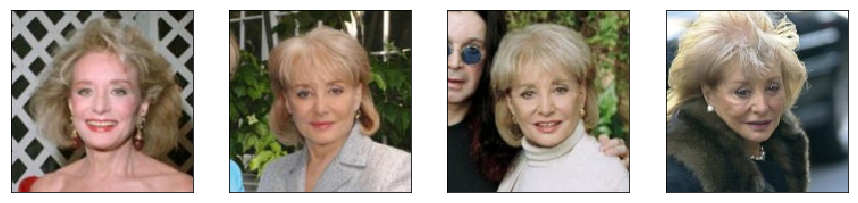

In [7]:
DATA_DIR = '../data/lfw'
data, n_pics = load_data(DATA_DIR)

print('Loaded %d pics.' % n_pics)

# load random guy and show his pics
random_guy = np.random.choice(list(data.keys()))
    
fig = plt.figure()
print('Random guy from LFW dataset')
fig.set_figheight(15)
fig.set_figwidth(15)
for i, pic in enumerate(data[random_guy]):
    utils.imshow(fig, pic, 1, len(data[random_guy]), i+1)

In [8]:
#initialize embeddings dict
emb_dict = {}
for guy in data:
    emb_dict[guy] = list(sess.run([embeddings], feed_dict={images_placeholder: np.array(data[guy]), phase_train_placeholder: False })[0])

### test the model

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


We sample the pic from Barbara_Walters.
---------------------------
I think, the pic belongs to Barbara_Walters.


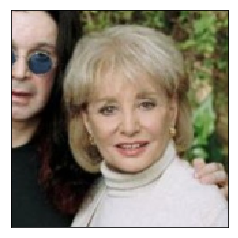

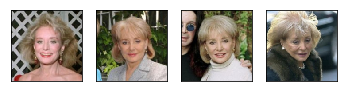

In [14]:
testing_data = copy.deepcopy(data)
testing_emb = copy.deepcopy(emb_dict)

# take random guy to test
guy = np.random.choice(list(testing_data.keys()))

# take random pic of the guy and remove taken pic from the data to avoid cheating
p_ind = np.random.randint(len(testing_data[guy]))
curr_pic = testing_data[guy].pop(p_ind)
curr_emb = emb_dict[guy].pop(p_ind)


#compute mean distance from random pic of the chosen guy to all the guys in the database
min_dist = sys.maxsize

mean_dist = []
for g in testing_data.keys():
    mean_embedding = np.mean(emb_dict[g], axis=0)
    
    # compute dist from guy's pic to mean embedding
    dist = np.linalg.norm(mean_embedding - curr_emb)
    mean_dist.append(dist)
    if min_dist > dist:
        min_dist = dist
        closest_guy = g
    #print('%s\t: %.2f' % (g,dist))

fig1 = plt.figure()
print('We sample the pic from %s.' % guy)
print('---------------------------')
print("I think, the pic belongs to %s." % closest_guy)

utils.imshow(fig1, curr_pic)
fig2 = plt.figure()
fig2.set_figheight(15)
fig2.set_figwidth(15)
# show no more than 10 pics of the guy
n_p = max(len(data[closest_guy]), 10) 
for i, pic in enumerate(data[closest_guy]):
    if i > n_p:
        break
    utils.imshow(fig2, pic, 1, n_p, i+1) 

### t-SNE for 2D representation of embeddings

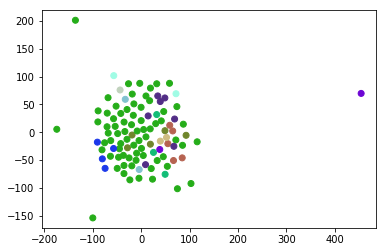

In [15]:
from sklearn.manifold import TSNE
arr = []
cols = []

for guy in emb_dict:
    color = utils.get_random_color()
    for p in emb_dict[guy]:
        arr.append(p)
        cols.append(color)        

model = TSNE(n_components=2, random_state=0, init='pca')
np.set_printoptions(suppress=True)
tsne_res = model.fit_transform(arr) 
plt.scatter(tsne_res[:,0], tsne_res[:,1], color=cols);